In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd

In [8]:
graph = Graph.from_json('ca_graph_islands_removed.json')

In [9]:
elections = [
    Election("PRES20", {"Democratic": "pre_20_dem_bid", "Republican": "pre_20_rep_tru"})
]

In [10]:
# Population updater, for computing how close to equality the district
# populations are. "total" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("pop", alias="population"),
               "countysplits": updaters.county_splits("countysplits","county"),
               "WHTP":updaters.Tally("pop_white", alias="WHTP"),
               "HISP":updaters.Tally("pop_hisp", alias="HISP"),
               "BLKP":updaters.Tally("pop_black", alias="BLKP")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [11]:
initial_partition = GeographicPartition(graph, assignment="congress2021", updaters=my_updaters)

In [12]:
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="pop",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

In [13]:
# To keep districts about as compact as the original plan, we bound the 
# number of cut edges at 2 times the number of cut edges in the initial plan.

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.03)

In [14]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000
)

In [15]:
# Show progress bar
from tqdm import tqdm

In [16]:
data = pd.DataFrame(
    sorted(partition["PRES20"].percents("Republican"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/10000 [00:00<?, ?it/s]

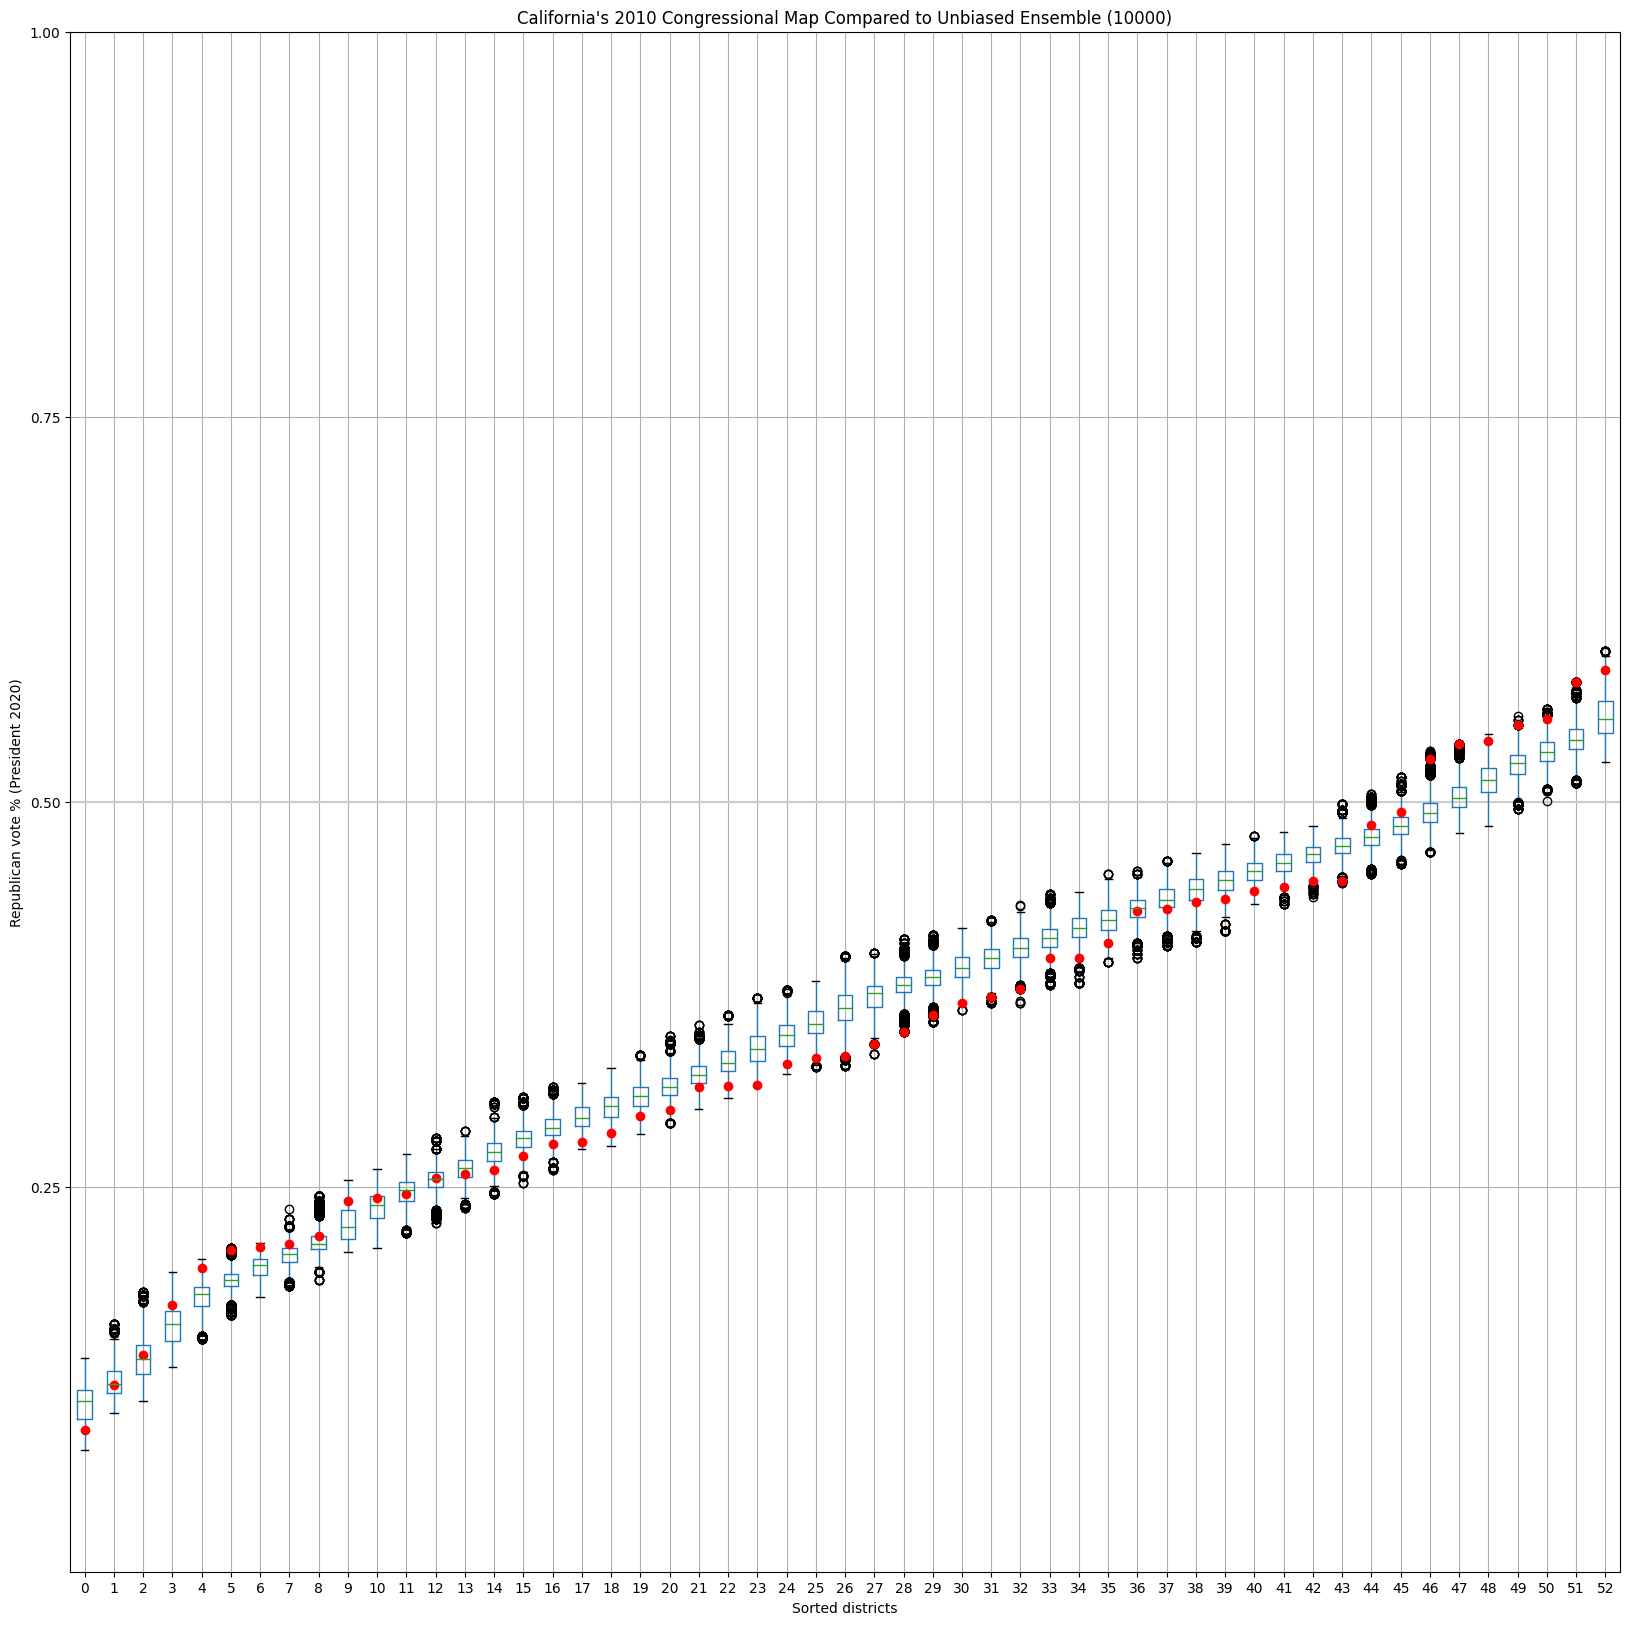

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("California's 2010 Congressional Map Compared to Unbiased Ensemble (10000)")
ax.set_ylabel("Republican vote % (President 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1])

plt.show()

In [18]:
fig.savefig('cd_21_10000.png')